# Geometric Computer Vision: Final Project
This notebook contains a revisited implementation of the paper: **Shape Non-rigid Kinematics (SNK): A Zero-Shot Method for Non-Rigid Shape Matching via Unsupervised Functional Map Regularized Reconstruction** by Attaiki and Ovsjanikov (2024).


## Imports

In [1]:
from pyFM.functional import FunctionalMapping
from model_SURFMNet import SURFMNet
import numpy as np
import trimesh
from pyFM.mesh import TriMesh
import torch
from torch_geometric.data import Batch
from diffusion_net import DiffusionData, DiffusionOperatorsTransform, DiffusionNet
from prism_decoder import PrismDecoder
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib import cm
from loss import PrismRegularizationLoss

## Load meshes
Let's first load the meshes of two dogs modified (non-rigid deformation using Blender):

In [2]:
# load some meshes
obj1 = r"./Samples/dog_small.obj"
obj2 = r"./Samples/dog_small_3.obj"
mesh1, mesh2 = TriMesh(obj1), TriMesh(obj2)

## Compute correspondance from mesh2 to mesh1 using functional maps
I chose the pyFM package investigated in HW3 to compute a first correspondance map between

In [3]:
process_params = {
    'n_ev': (70, 70),  # Number of eigenvalues on source and Target
    'subsample_step': 20,  # In order not to use too many descriptors
    'descr_type': 'WKS',  # WKS or HKS
}           
model = FunctionalMapping(mesh1, mesh2)
model.preprocess(**process_params, verbose=False)
fit_params = {
    'w_descr': 1e0,
    'w_lap': 1e-2,
    'w_dcomm': 1e-1,
    'w_orient': 0
}
model.fit(**fit_params, verbose=False)
p2p_21 = model.get_p2p(n_jobs=1)

In [4]:
import meshplot as mp

def double_plot_mp(myMesh1,myMesh2,cmap1=None,cmap2=None):
    p = mp.plot(myMesh1.vertlist, myMesh1.facelist, c=cmap1)
    v2_translated = myMesh2.vertlist.copy()
    f2_translated = myMesh2.facelist.copy()
    myMesh2_translated = TriMesh(v2_translated, f2_translated)
    myMesh2_translated.vertlist[:,0] = myMesh2_translated.vertlist[:,0] + 30 
    p.add_mesh(myMesh2_translated.vertlist, myMesh2_translated.facelist, c=cmap2)
    
def visu(vertices):
    min_coord,max_coord = np.min(vertices,axis=0,keepdims=True),np.max(vertices,axis=0,keepdims=True)
    cmap = (vertices-min_coord)/(max_coord-min_coord)
    return cmap

cmap1 = visu(mesh1.vertlist); cmap2 = cmap1[p2p_21]
double_plot_mp(mesh1,mesh2,cmap1,cmap2)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0212688…

## Compute latent vector
Following section 4.2 in the paper, we compute a latent vector (of length d1) per feature using DiffusionNet++ module, then apply max pooling to get a vector l of length d1.
Then we aim to reconstruct the first shape by concatenating l to each feature of the second mesh and passing those to the decoder. 

In [5]:
def compute_l(my_batch, diffusion_net):
    my_batch.x = my_batch.pos.clone()[0]
    output = diffusion_net(my_batch)
    l = output.x.max(dim=0).values
    return l
    
def reconstruct_s2(my_batch2, v2_t, l, decoder):
    l_expanded = l.unsqueeze(0).repeat(v2_t.shape[0],1)
    my_batch2.x = torch.cat((v2_t,l_expanded),dim=1) #.unsqueeze(0)
    s3 = decoder(my_batch2)
    return s3

## Encode the first mesh using a DiffusionNet++ model

In [6]:
mesh1_diff = trimesh.load(obj1)
v1, f1 = np.array(mesh1.vertices), np.array(mesh1.faces)
v1_t = torch.from_numpy(v1)
f1_t = torch.from_numpy(f1)
data1 = DiffusionData(pos=v1_t, face=f1_t.T)
diffusion_transform = DiffusionOperatorsTransform(n_eig=50)  #97 compute the diffusion net operators with 97 eigenvalues
data1 = diffusion_transform(data1)
my_batch = Batch.from_data_list([data1])
my_batch.pos = my_batch.pos.unsqueeze(0) 


In [7]:
mesh2_diff = trimesh.load(obj2)
v2, f2 = np.array(mesh2.vertices), np.array(mesh2.faces)
data2 = DiffusionData(pos=torch.from_numpy(v2), face=torch.from_numpy(f2).T)
diffusion_transform = DiffusionOperatorsTransform(n_eig=50)  #97 compute the diffusion net operators with 97 eigenvalues
data2 = diffusion_transform(data2)
my_batch2 = Batch.from_data_list([data2])
my_batch2.pos = my_batch2.pos.unsqueeze(0) 
#######
v2_t = torch.Tensor(v2)

In [8]:
my_batch.pos.requires_grad = True
v2_t.requires_grad = True
my_batch2.pos.requires_grad = True

In [9]:
print(my_batch)
print(my_batch2)

DiffusionDataBatch(pos=[1, 541, 3], face=[3, 1078], mass=[541, 541, nnz=541], evals=[50], evecs=[541, 50], gradX=[541, 541, nnz=3775], gradY=[541, 541, nnz=3775], L=[541, 541, nnz=3775], batch=[541], ptr=[2])
DiffusionDataBatch(pos=[1, 487, 3], face=[3, 970], mass=[487, 487, nnz=487], evals=[50], evecs=[487, 50], gradX=[487, 487, nnz=3397], gradY=[487, 487, nnz=3397], L=[487, 487, nnz=3397], batch=[487], ptr=[2])


In [10]:
from torch.sparse import mm
from model_SURFMNet import FunctionalMapNet
diffusion_net = DiffusionNet(3, 42)
my_batch.x = my_batch.pos.clone()[0]
my_batch2.x = my_batch2.pos.clone()[0]
output1 = diffusion_net(my_batch)
output2 = diffusion_net(my_batch2)
evecs_T_1 = output1.evecs.t() @ output1.mass.to_dense()
evecs_T_2 = output2.evecs.t() @ output2.mass.to_dense()
fm_net = FunctionalMapNet() #SURFMNet
C1, C2 = fm_net(output1.x.unsqueeze(0), output2.x.unsqueeze(0), evecs_T_1.unsqueeze(0), evecs_T_2.unsqueeze(0))
emb1 = output1.evecs #evects1[:, :k1] @ FM_12.T
emb2 = output2.evecs @ C1.squeeze() #evects1[:, :k1] @ FM_12.T
dist = torch.cdist(emb1, emb2)#, dim=1, p=None)
knn = dist.topk(1, largest=False, dim=0)

In [11]:
def double_plot(myMesh1, myMesh2, cmap1=None, cmap2=None, title1='Mesh1',title2='Mesh2'):
    fig = plt.figure(figsize=plt.figaspect(0.5))
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.plot_trisurf(myMesh1.vertlist[:, 0], myMesh1.vertlist[:, 1], myMesh1.vertlist[:, 2],
                     triangles=myMesh1.facelist, cmap='viridis', facecolors=cmap1)
    ax1.set_title(title1)
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.plot_trisurf(myMesh2.vertlist[:, 0], myMesh2.vertlist[:, 1], myMesh2.vertlist[:, 2],
                     triangles=myMesh2.facelist, cmap='viridis', facecolors=cmap2)
    ax2.set_title(title2)
# cmap1 = visu(v1_remapped)
# cmap2 = visu(s3.features.detach().squeeze(0).numpy())
# double_plot(mesh1, mesh2, cmap1, cmap2, '', '')

In [12]:
def visu_face_colors(s1_faces_raw, s1_faces, s2_faces, s3_faces):

    cmap = cm.get_cmap('viridis', s3_faces.shape[0])  # Use a colormap with 500 distinct colors
    face_colors = cmap(np.linspace(0, 1, s3_faces.shape[0]))
    
    average_z = np.mean(s2_faces[:, :, 2], axis=1)
    sorted_indices = np.argsort(average_z)
    
    sorted_s3_faces = s3_faces[sorted_indices]
    sorted_s2_faces = s2_faces[sorted_indices]
    sorted_s1_faces = s1_faces[sorted_indices]
    fig = plt.figure()
    ax1 = fig.add_subplot(131, projection='3d')
    ax2 = fig.add_subplot(132, projection='3d')
    ax3 = fig.add_subplot(133, projection='3d')
    for i, face in enumerate(s3_faces):
        # poly3d = [[vertices[vert_idx] for vert_idx in face]]
        poly3d_1 = [sorted_s1_faces[i]]
        poly3d_2 = [sorted_s2_faces[i]]
        poly3d_1_raw = [s1_faces_raw[i]]
        poly3d_3 = [sorted_s3_faces[i]]
        ax1.add_collection3d(Poly3DCollection(poly3d_1, facecolors=face_colors[i], linewidths=1, edgecolors=None, alpha=.8))
        ax1.add_collection3d(Poly3DCollection(poly3d_1_raw, facecolors='b', linewidths=1, edgecolors=None, alpha=.1))
        ax2.add_collection3d(Poly3DCollection(poly3d_2, facecolors=face_colors[i], linewidths=1, edgecolors=None, alpha=.8))
        ax3.add_collection3d(Poly3DCollection(poly3d_3, facecolors=face_colors[i], linewidths=1, edgecolors=None, alpha=.8))
    ax1.set_xlim([s1_faces[:,:,0].min(), s1_faces[:,:,0].max()])
    ax1.set_ylim([s1_faces[:,:,1].min(), s1_faces[:,:,1].max()])
    ax1.set_zlim([s1_faces[:,:,2].min(), s1_faces[:,:,2].max()])
    ax2.set_xlim([s2_faces[:,:,0].min(), s2_faces[:,:,0].max()])
    ax2.set_ylim([s2_faces[:,:,1].min(), s2_faces[:,:,1].max()])
    ax2.set_zlim([s2_faces[:,:,2].min(), s2_faces[:,:,2].max()])
    ax3.set_xlim([s3_faces[:,:,0].min(), s3_faces[:,:,0].max()])
    ax3.set_ylim([s3_faces[:,:,1].min(), s3_faces[:,:,1].max()])
    ax3.set_zlim([s3_faces[:,:,2].min(), s3_faces[:,:,2].max()])
    plt.show()

In [13]:
def compute_centroid(face):
    return np.mean(face, axis=0)

def find_closest_faces(lf1, lf2):
    centroids_lf1 = np.array([compute_centroid(face) for face in lf1])
    centroids_lf2 = np.array([compute_centroid(face) for face in lf2])
    
    closest_faces = []
    closest_faces_idx = []
    
    for centroid in centroids_lf2:
        distances = np.linalg.norm(centroids_lf1 - centroid, axis=1)
        closest_face_idx = np.argmin(distances)
        while closest_face_idx in closest_faces_idx:
            distances[closest_face_idx] = max(distances) + 1
            closest_face_idx = np.argmin(distances)
        closest_faces.append(lf1[closest_face_idx])
        closest_faces_idx.append(closest_face_idx)
    return closest_faces_idx

In [14]:
v1s = my_batch.pos.reshape(-1, 3)
f1s = my_batch.face.t()
s1_faces_tmp = v1s[f1s].detach().numpy()

In [15]:
def compute_fmaps(my_batch, my_batch2, diff_net_fts):
    my_batch.x = my_batch.pos.clone()[0]
    my_batch2.x = my_batch2.pos.clone()[0]
    output1 = diff_net_fts(my_batch)
    output2 = diff_net_fts(my_batch2)
    evecs_T_1 = output1.evecs.t() @ output1.mass.to_dense()
    evecs_T_2 = output2.evecs.t() @ output2.mass.to_dense()
    fm_net = FunctionalMapNet() #SURFMNet
    C1, C2 = fm_net(output1.x.unsqueeze(0), output2.x.unsqueeze(0), evecs_T_1.unsqueeze(0), evecs_T_2.unsqueeze(0))
    emb1 = output1.evecs #evects1[:, :k1] @ FM_12.T
    emb2 = output2.evecs @ C1.squeeze() #evects1[:, :k1] @ FM_12.T
    dist = torch.cdist(emb1, emb2)#, dim=1, p=None)
    knn = dist.topk(1, largest=False, dim=0)
    p2p_21 = knn.indices.squeeze(0)
    return C1, C2, p2p_21

In [16]:
L_SPACE_SIZE = 42
diff_net_fts  = DiffusionNet(3, 42)
diffusion_net = DiffusionNet(3, L_SPACE_SIZE)
decoder = PrismDecoder(v1.shape[1]+L_SPACE_SIZE, v1.shape[0])
get_energy_loss = PrismRegularizationLoss(100)

In [17]:
diffusion_net.first_lin.weight.grad

  0%|                                                                                                                                                                                   | 0/10000 [00:00<?, ?it/s]C:\Users\Hadassa-Port\AppData\Local\Temp\ipykernel_21200\2945219647.py:19: UserWarning: Using a target size (torch.Size([1, 487, 3])) that is different to the input size (torch.Size([487, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss_MSE = torch.nn.functional.mse_loss(torch.Tensor(v1_remapped),s3.features)
C:\Users\Hadassa-Port\AppData\Local\Temp\ipykernel_21200\2945219647.py:20: UserWarning: Using a target size (torch.Size([50, 50])) that is different to the input size (torch.Size([1, 50, 50])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss_FMAPS_1 = torch.nn.functional.mse_loss(C1@C2, torch.eye(50)) + torch.nn.functional.mse_loss(C1.transpose(1,2

Epoch 0: MSE loss = 138.4190216064453
Epoch 0: Energy loss = 303.43438720703125
Epoch 0: f1 loss = 0.014822783879935741
Epoch 0: f2 loss = 0.07625257223844528


C:\Users\Hadassa-Port\AppData\Local\Temp\ipykernel_21200\2975563605.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', s3_faces.shape[0])  # Use a colormap with 500 distinct colors


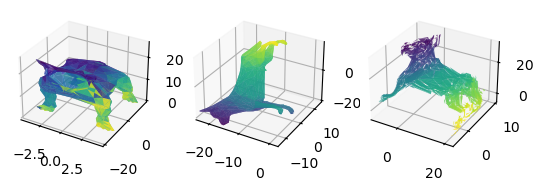

101.306755:   1%|█▌                                                                                                                                                         | 100/10000 [02:40<3:41:11,  1.34s/it]

Epoch 100: MSE loss = 84.59368896484375
Epoch 100: Energy loss = 15.418474197387695
Epoch 100: f1 loss = 0.5673588514328003
Epoch 100: f2 loss = 0.7272352576255798


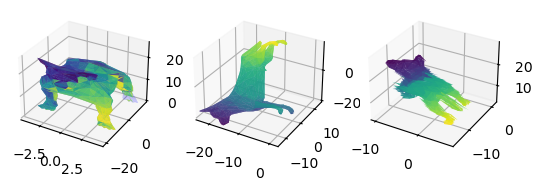

389.330383:   2%|███                                                                                                                                                        | 200/10000 [05:17<3:25:09,  1.26s/it]

Epoch 200: MSE loss = 62.243560791015625
Epoch 200: Energy loss = 14.786492347717285
Epoch 200: f1 loss = 116.22406005859375
Epoch 200: f2 loss = 196.07626342773438


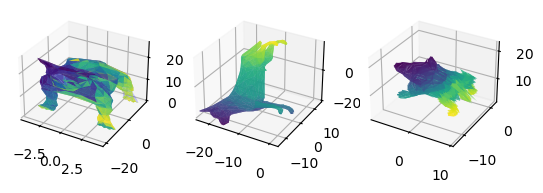

78.396454:   3%|████▋                                                                                                                                                       | 300/10000 [07:53<3:23:45,  1.26s/it]

Epoch 300: MSE loss = 62.15915298461914
Epoch 300: Energy loss = 16.153026580810547
Epoch 300: f1 loss = 0.01310831680893898
Epoch 300: f2 loss = 0.07116103917360306


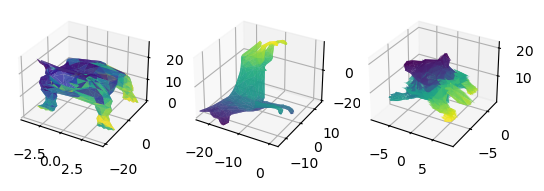

110.424339:   4%|██████▏                                                                                                                                                    | 400/10000 [10:30<3:19:16,  1.25s/it]

Epoch 400: MSE loss = 85.4991683959961
Epoch 400: Energy loss = 17.634859085083008
Epoch 400: f1 loss = 0.0022359283175319433
Epoch 400: f2 loss = 7.288074493408203


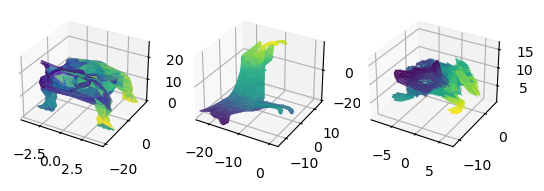

64.594574:   5%|███████▊                                                                                                                                                    | 500/10000 [13:03<3:17:11,  1.25s/it]

Epoch 500: MSE loss = 54.403465270996094
Epoch 500: Energy loss = 9.752196311950684
Epoch 500: f1 loss = 0.37450987100601196
Epoch 500: f2 loss = 0.06440340727567673


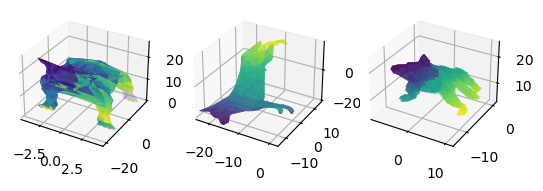

191.702759:   6%|█████████▎                                                                                                                                                 | 600/10000 [15:42<3:19:24,  1.27s/it]

Epoch 600: MSE loss = 158.76788330078125
Epoch 600: Energy loss = 21.617042541503906
Epoch 600: f1 loss = 8.677755355834961
Epoch 600: f2 loss = 2.6400654315948486


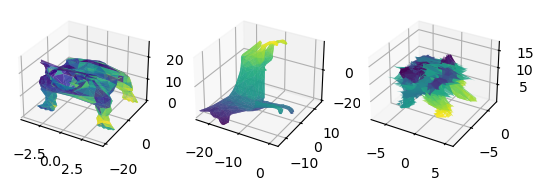

205.595535:   7%|██████████▊                                                                                                                                                | 700/10000 [18:30<3:09:08,  1.22s/it]

Epoch 700: MSE loss = 192.72781372070312
Epoch 700: Energy loss = 11.030577659606934
Epoch 700: f1 loss = 0.14665056765079498
Epoch 700: f2 loss = 1.6904958486557007


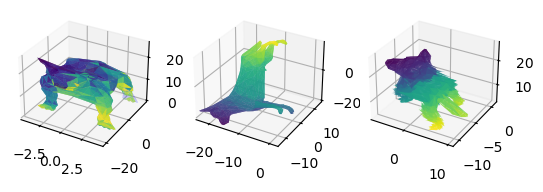

142.739319:   8%|████████████▍                                                                                                                                              | 800/10000 [21:05<3:09:25,  1.24s/it]

Epoch 800: MSE loss = 131.19796752929688
Epoch 800: Energy loss = 11.491016387939453
Epoch 800: f1 loss = 0.03889824077486992
Epoch 800: f2 loss = 0.011435823515057564


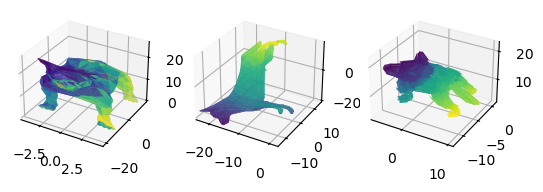

76.922302:   9%|██████████████                                                                                                                                              | 900/10000 [23:49<3:42:16,  1.47s/it]

Epoch 900: MSE loss = 64.81265258789062
Epoch 900: Energy loss = 11.948801040649414
Epoch 900: f1 loss = 0.005377727095037699
Epoch 900: f2 loss = 0.1554747372865677


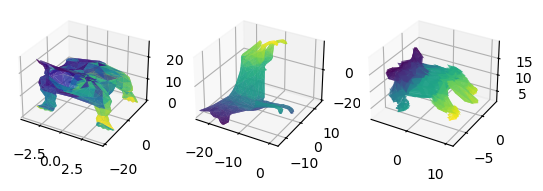

199.078140:  10%|███████████████▍                                                                                                                                          | 1000/10000 [26:58<3:32:11,  1.41s/it]

Epoch 1000: MSE loss = 74.0458755493164
Epoch 1000: Energy loss = 11.746149063110352
Epoch 1000: f1 loss = 112.19220733642578
Epoch 1000: f2 loss = 1.0939030647277832


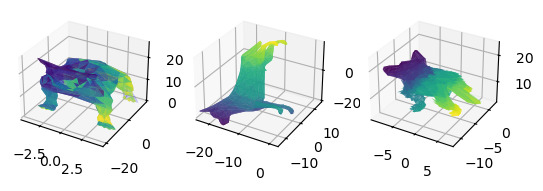

51.597801:  11%|█████████████████                                                                                                                                          | 1100/10000 [30:21<4:00:55,  1.62s/it]

Epoch 1100: MSE loss = 35.986412048339844
Epoch 1100: Energy loss = 15.169523239135742
Epoch 1100: f1 loss = 0.029017485678195953
Epoch 1100: f2 loss = 0.4128505289554596


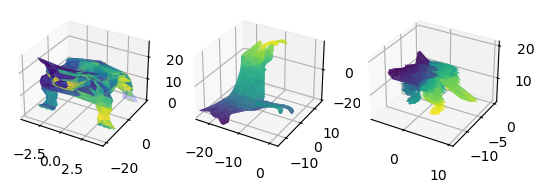

73.428291:  12%|██████████████████▌                                                                                                                                        | 1200/10000 [33:41<3:11:45,  1.31s/it]

Epoch 1200: MSE loss = 57.123775482177734
Epoch 1200: Energy loss = 16.2049503326416
Epoch 1200: f1 loss = 0.08186553418636322
Epoch 1200: f2 loss = 0.017696553841233253


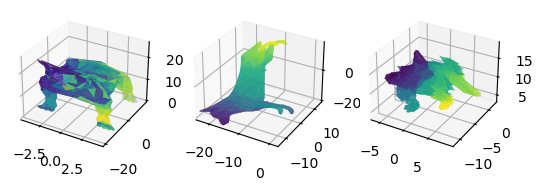

46.046829:  13%|████████████████████▏                                                                                                                                      | 1300/10000 [37:10<3:11:11,  1.32s/it]

Epoch 1300: MSE loss = 31.36875343322754
Epoch 1300: Energy loss = 14.604534149169922
Epoch 1300: f1 loss = 0.001092314487323165
Epoch 1300: f2 loss = 0.07245117425918579


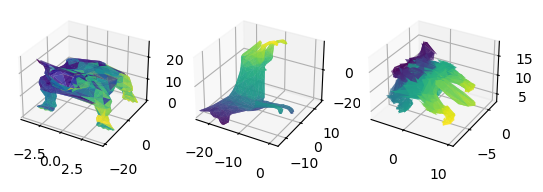

118.135956:  14%|█████████████████████▌                                                                                                                                    | 1400/10000 [41:14<3:11:47,  1.34s/it]

Epoch 1400: MSE loss = 106.15186309814453
Epoch 1400: Energy loss = 11.93130111694336
Epoch 1400: f1 loss = 0.04649919271469116
Epoch 1400: f2 loss = 0.006287424359470606


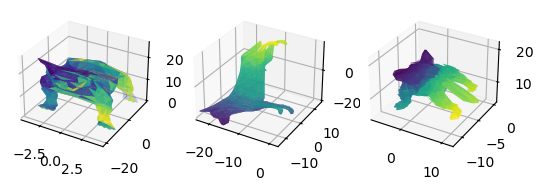

71.062225:  15%|███████████████████████▎                                                                                                                                   | 1500/10000 [44:36<4:06:58,  1.74s/it]

Epoch 1500: MSE loss = 50.54459762573242
Epoch 1500: Energy loss = 20.486000061035156
Epoch 1500: f1 loss = 0.03056538663804531
Epoch 1500: f2 loss = 0.0010624895803630352


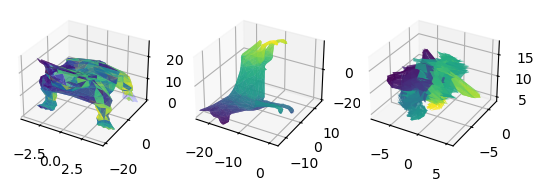

103.634705:  16%|████████████████████████▋                                                                                                                                 | 1600/10000 [48:37<4:20:22,  1.86s/it]

Epoch 1600: MSE loss = 88.33651733398438
Epoch 1600: Energy loss = 15.207642555236816
Epoch 1600: f1 loss = 0.0004653192590922117
Epoch 1600: f2 loss = 0.09008392691612244


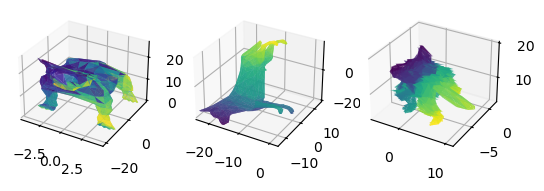

61.896221:  17%|██████████████████████████▎                                                                                                                                | 1700/10000 [52:01<3:33:07,  1.54s/it]

Epoch 1700: MSE loss = 48.62522506713867
Epoch 1700: Energy loss = 13.07433032989502
Epoch 1700: f1 loss = 0.006607468705624342
Epoch 1700: f2 loss = 0.19005973637104034


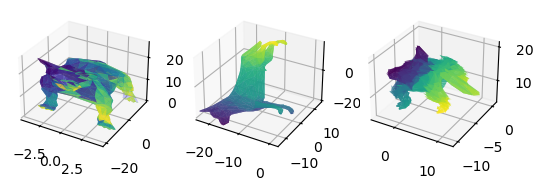

58135.273438:  18%|███████████████████████████▎                                                                                                                            | 1800/10000 [55:19<3:29:30,  1.53s/it]

Epoch 1800: MSE loss = 27.78762435913086
Epoch 1800: Energy loss = 17.796245574951172
Epoch 1800: f1 loss = 58011.9375
Epoch 1800: f2 loss = 77.75072479248047


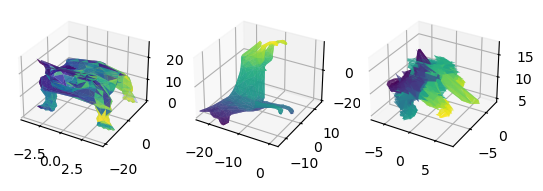

134.287643:  19%|█████████████████████████████▎                                                                                                                            | 1900/10000 [58:45<3:36:09,  1.60s/it]

Epoch 1900: MSE loss = 118.1742172241211
Epoch 1900: Energy loss = 15.890031814575195
Epoch 1900: f1 loss = 0.19845710694789886
Epoch 1900: f2 loss = 0.02494070865213871


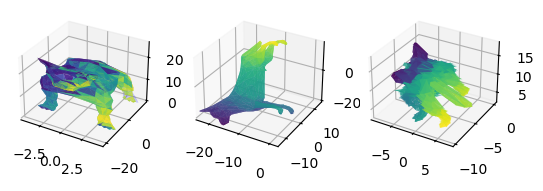

91.834633:  20%|██████████████████████████████▌                                                                                                                          | 2000/10000 [1:02:09<3:05:55,  1.39s/it]

Epoch 2000: MSE loss = 66.97698974609375
Epoch 2000: Energy loss = 13.020589828491211
Epoch 2000: f1 loss = 11.77174186706543
Epoch 2000: f2 loss = 0.06530854105949402


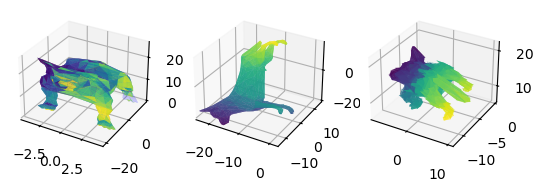

194.612015:  21%|███████████████████████████████▉                                                                                                                        | 2100/10000 [1:05:34<2:55:52,  1.34s/it]

Epoch 2100: MSE loss = 44.03076934814453
Epoch 2100: Energy loss = 13.104503631591797
Epoch 2100: f1 loss = 107.11314392089844
Epoch 2100: f2 loss = 30.36359977722168


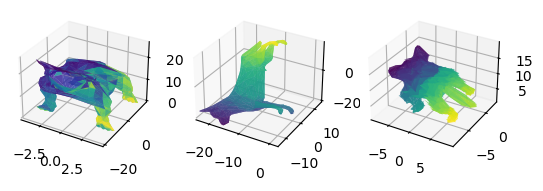

135.633987:  22%|█████████████████████████████████▍                                                                                                                      | 2200/10000 [1:08:56<2:54:38,  1.34s/it]

Epoch 2200: MSE loss = 125.95999908447266
Epoch 2200: Energy loss = 8.396061897277832
Epoch 2200: f1 loss = 0.5419024229049683
Epoch 2200: f2 loss = 0.7360300421714783


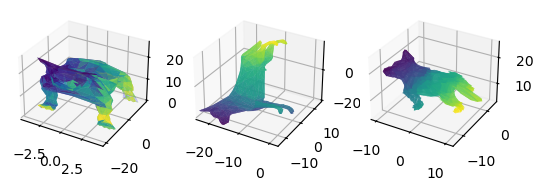

135.777557:  23%|██████████████████████████████████▉                                                                                                                     | 2300/10000 [1:12:09<3:20:24,  1.56s/it]

Epoch 2300: MSE loss = 120.1104736328125
Epoch 2300: Energy loss = 15.652190208435059
Epoch 2300: f1 loss = 0.0036718028131872416
Epoch 2300: f2 loss = 0.011231154203414917


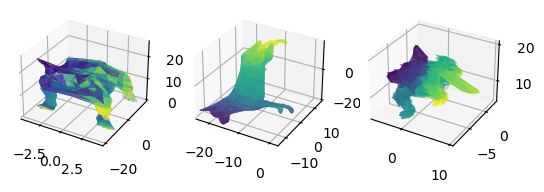

92.570679:  24%|████████████████████████████████████▋                                                                                                                    | 2400/10000 [1:15:31<2:49:36,  1.34s/it]

Epoch 2400: MSE loss = 76.92635345458984
Epoch 2400: Energy loss = 15.631635665893555
Epoch 2400: f1 loss = 0.0034903977066278458
Epoch 2400: f2 loss = 0.009200639091432095


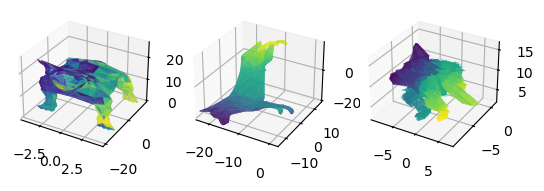

71.552452:  25%|██████████████████████████████████████▎                                                                                                                  | 2500/10000 [1:18:57<2:57:07,  1.42s/it]

Epoch 2500: MSE loss = 47.19223403930664
Epoch 2500: Energy loss = 14.415288925170898
Epoch 2500: f1 loss = 9.758109092712402
Epoch 2500: f2 loss = 0.1868216097354889


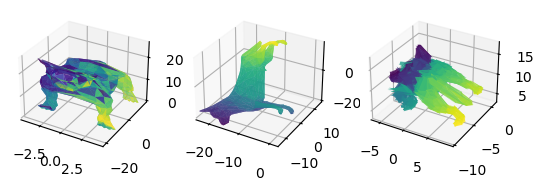

81.699722:  26%|███████████████████████████████████████▊                                                                                                                 | 2600/10000 [1:22:24<3:18:14,  1.61s/it]

Epoch 2600: MSE loss = 70.85128021240234
Epoch 2600: Energy loss = 10.847509384155273
Epoch 2600: f1 loss = 0.0001780273742042482
Epoch 2600: f2 loss = 0.0007531830342486501


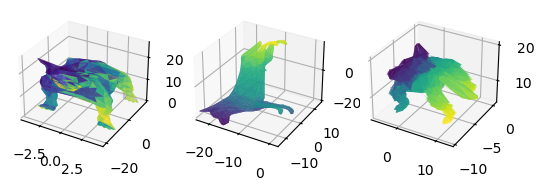

145.625000:  27%|█████████████████████████████████████████                                                                                                               | 2700/10000 [1:25:45<3:09:30,  1.56s/it]

Epoch 2700: MSE loss = 130.90032958984375
Epoch 2700: Energy loss = 12.551244735717773
Epoch 2700: f1 loss = 1.1347119808197021
Epoch 2700: f2 loss = 1.0387150049209595


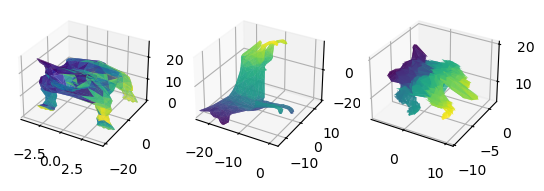

116.853851:  28%|██████████████████████████████████████████▌                                                                                                             | 2800/10000 [1:29:07<2:50:08,  1.42s/it]

Epoch 2800: MSE loss = 104.1912612915039
Epoch 2800: Energy loss = 12.661748886108398
Epoch 2800: f1 loss = 8.419603545917198e-05
Epoch 2800: f2 loss = 0.0007531362934969366


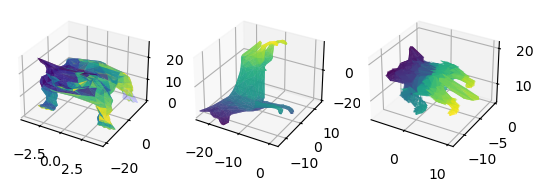

110.282585:  29%|████████████████████████████████████████████                                                                                                            | 2900/10000 [1:32:30<2:46:57,  1.41s/it]

Epoch 2900: MSE loss = 96.53112030029297
Epoch 2900: Energy loss = 13.42004680633545
Epoch 2900: f1 loss = 0.2557222545146942
Epoch 2900: f2 loss = 0.07569536566734314


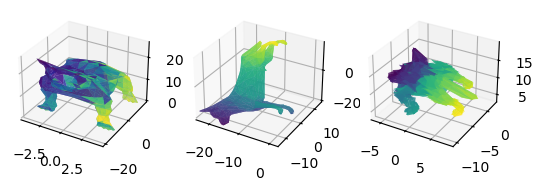

126.544975:  30%|█████████████████████████████████████████████▌                                                                                                          | 3000/10000 [1:35:55<2:59:16,  1.54s/it]

Epoch 3000: MSE loss = 113.17498779296875
Epoch 3000: Energy loss = 13.07945442199707
Epoch 3000: f1 loss = 0.0007745520561002195
Epoch 3000: f2 loss = 0.2897607386112213


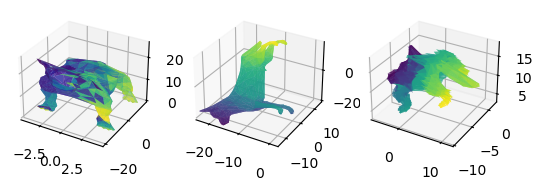

101.915543:  31%|███████████████████████████████████████████████                                                                                                         | 3100/10000 [1:39:20<3:05:09,  1.61s/it]

Epoch 3100: MSE loss = 85.51105499267578
Epoch 3100: Energy loss = 16.215091705322266
Epoch 3100: f1 loss = 0.1856037974357605
Epoch 3100: f2 loss = 0.0037972840946167707


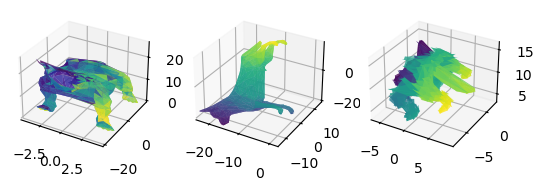

130.510254:  32%|████████████████████████████████████████████████▋                                                                                                       | 3200/10000 [1:42:48<2:30:15,  1.33s/it]

Epoch 3200: MSE loss = 113.7905044555664
Epoch 3200: Energy loss = 16.666759490966797
Epoch 3200: f1 loss = 0.04575716704130173
Epoch 3200: f2 loss = 0.007230190560221672


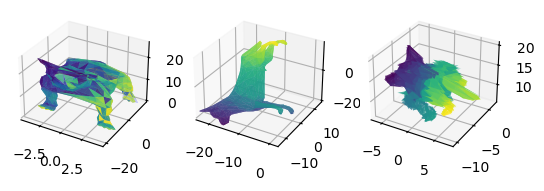

52.753689:  33%|██████████████████████████████████████████████████▍                                                                                                      | 3300/10000 [1:46:15<3:00:43,  1.62s/it]

Epoch 3300: MSE loss = 34.67832565307617
Epoch 3300: Energy loss = 14.27651596069336
Epoch 3300: f1 loss = 3.779261589050293
Epoch 3300: f2 loss = 0.019586067646741867


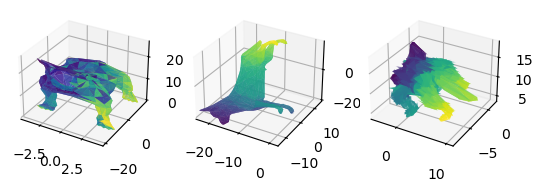

69.109978:  34%|████████████████████████████████████████████████████                                                                                                     | 3400/10000 [1:49:43<2:49:32,  1.54s/it]

Epoch 3400: MSE loss = 57.740577697753906
Epoch 3400: Energy loss = 11.366235733032227
Epoch 3400: f1 loss = 0.002429555868729949
Epoch 3400: f2 loss = 0.0007368364022113383


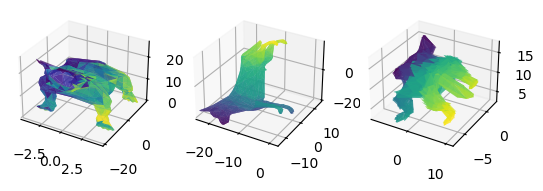

134.334839:  35%|█████████████████████████████████████████████████████▏                                                                                                  | 3500/10000 [1:53:06<2:26:15,  1.35s/it]

Epoch 3500: MSE loss = 123.61683654785156
Epoch 3500: Energy loss = 10.593358993530273
Epoch 3500: f1 loss = 0.01946951448917389
Epoch 3500: f2 loss = 0.10517560690641403


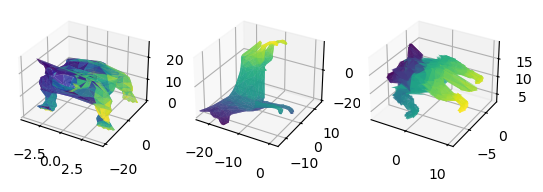

159.782883:  36%|██████████████████████████████████████████████████████▋                                                                                                 | 3600/10000 [1:56:29<2:34:28,  1.45s/it]

Epoch 3600: MSE loss = 120.44023895263672
Epoch 3600: Energy loss = 13.642826080322266
Epoch 3600: f1 loss = 11.408793449401855
Epoch 3600: f2 loss = 14.291030883789062


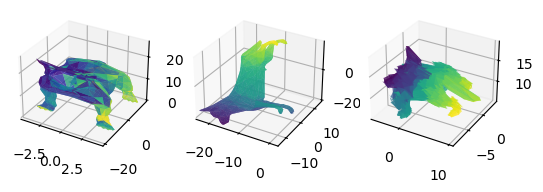

124.012421:  37%|████████████████████████████████████████████████████████▏                                                                                               | 3700/10000 [1:59:53<2:40:21,  1.53s/it]

Epoch 3700: MSE loss = 108.57910919189453
Epoch 3700: Energy loss = 15.23764705657959
Epoch 3700: f1 loss = 0.1879320740699768
Epoch 3700: f2 loss = 0.007730198558419943


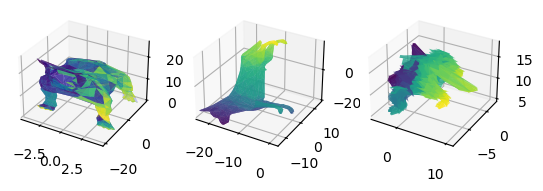

124.911423:  38%|█████████████████████████████████████████████████████████▊                                                                                              | 3800/10000 [2:03:21<2:22:06,  1.38s/it]

Epoch 3800: MSE loss = 108.26319885253906
Epoch 3800: Energy loss = 16.00284194946289
Epoch 3800: f1 loss = 0.10270579159259796
Epoch 3800: f2 loss = 0.542682409286499


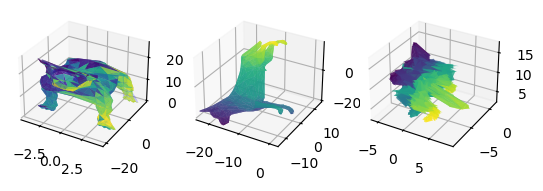

123.245995:  39%|███████████████████████████████████████████████████████████▎                                                                                            | 3900/10000 [2:06:49<2:33:45,  1.51s/it]

Epoch 3900: MSE loss = 108.59770965576172
Epoch 3900: Energy loss = 14.602813720703125
Epoch 3900: f1 loss = 0.0022757297847419977
Epoch 3900: f2 loss = 0.04319242760539055


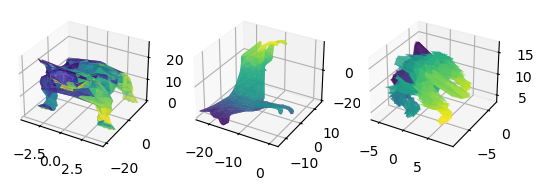

119.962463:  40%|████████████████████████████████████████████████████████████▊                                                                                           | 4000/10000 [2:10:18<2:35:05,  1.55s/it]

Epoch 4000: MSE loss = 104.53607177734375
Epoch 4000: Energy loss = 15.408740997314453
Epoch 4000: f1 loss = 0.012941724620759487
Epoch 4000: f2 loss = 0.004710355773568153


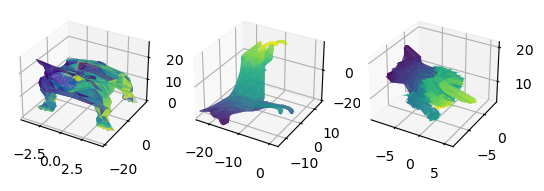

56.942379:  41%|██████████████████████████████████████████████████████████████▋                                                                                          | 4100/10000 [2:13:46<2:14:24,  1.37s/it]

Epoch 4100: MSE loss = 44.5427360534668
Epoch 4100: Energy loss = 12.300982475280762
Epoch 4100: f1 loss = 0.0912981852889061
Epoch 4100: f2 loss = 0.007359548006206751


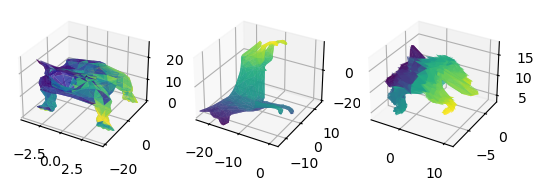

181.086777:  42%|███████████████████████████████████████████████████████████████▊                                                                                        | 4200/10000 [2:17:11<2:28:31,  1.54s/it]

Epoch 4200: MSE loss = 39.45859146118164
Epoch 4200: Energy loss = 12.357421875
Epoch 4200: f1 loss = 128.32054138183594
Epoch 4200: f2 loss = 0.9502289891242981


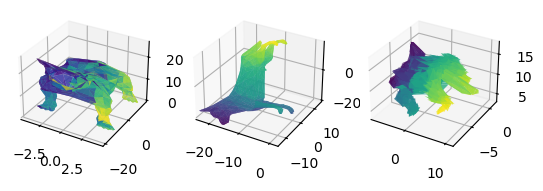

81.503967:  43%|█████████████████████████████████████████████████████████████████▊                                                                                       | 4300/10000 [2:20:39<2:30:09,  1.58s/it]

Epoch 4300: MSE loss = 70.4593276977539
Epoch 4300: Energy loss = 11.044417381286621
Epoch 4300: f1 loss = 0.00013098414638079703
Epoch 4300: f2 loss = 8.919739775592461e-05


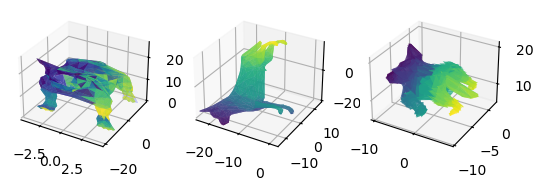

49.869175:  44%|███████████████████████████████████████████████████████████████████▎                                                                                     | 4400/10000 [2:24:01<2:07:05,  1.36s/it]

Epoch 4400: MSE loss = 33.705116271972656
Epoch 4400: Energy loss = 15.837178230285645
Epoch 4400: f1 loss = 0.3191782832145691
Epoch 4400: f2 loss = 0.007703568786382675


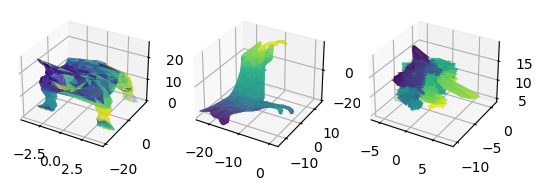

59.592987:  45%|████████████████████████████████████████████████████████████████████▊                                                                                    | 4500/10000 [2:27:28<2:29:18,  1.63s/it]

Epoch 4500: MSE loss = 45.57386779785156
Epoch 4500: Energy loss = 13.584615707397461
Epoch 4500: f1 loss = 0.0007912294240668416
Epoch 4500: f2 loss = 0.4337102472782135


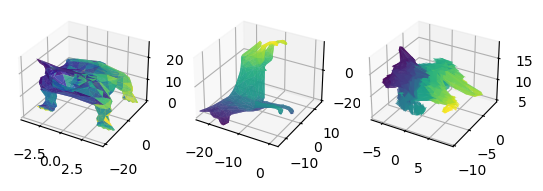

144.371002:  46%|█████████████████████████████████████████████████████████████████████▉                                                                                  | 4600/10000 [2:30:53<2:23:04,  1.59s/it]

Epoch 4600: MSE loss = 91.05794525146484
Epoch 4600: Energy loss = 12.067108154296875
Epoch 4600: f1 loss = 0.07221687585115433
Epoch 4600: f2 loss = 41.17372512817383


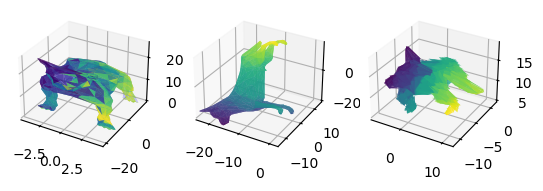

133.939484:  47%|███████████████████████████████████████████████████████████████████████▍                                                                                | 4700/10000 [2:34:17<1:59:26,  1.35s/it]

Epoch 4700: MSE loss = 120.99455261230469
Epoch 4700: Energy loss = 12.811744689941406
Epoch 4700: f1 loss = 0.04469681158661842
Epoch 4700: f2 loss = 0.08848919719457626


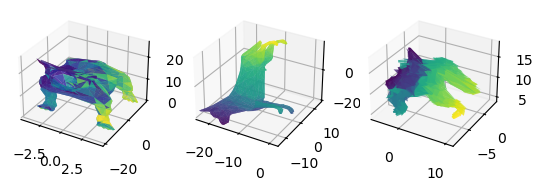

102.258751:  48%|████████████████████████████████████████████████████████████████████████▉                                                                               | 4800/10000 [2:37:43<2:15:22,  1.56s/it]

Epoch 4800: MSE loss = 85.24440002441406
Epoch 4800: Energy loss = 13.454198837280273
Epoch 4800: f1 loss = 3.0868983268737793
Epoch 4800: f2 loss = 0.47325554490089417


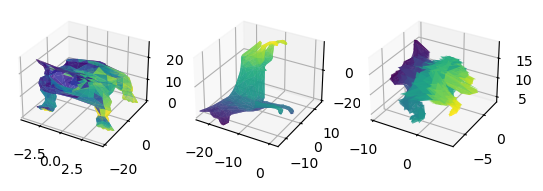

113.419037:  49%|██████████████████████████████████████████████████████████████████████████▍                                                                             | 4900/10000 [2:41:10<2:10:04,  1.53s/it]

Epoch 4900: MSE loss = 101.9107666015625
Epoch 4900: Energy loss = 11.457845687866211
Epoch 4900: f1 loss = 0.008396034128963947
Epoch 4900: f2 loss = 0.04202989861369133


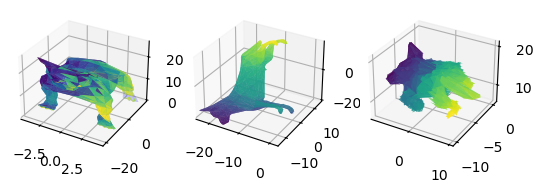

105.511551:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5000/10000 [2:44:35<1:48:17,  1.30s/it]

Epoch 5000: MSE loss = 95.16519165039062
Epoch 5000: Energy loss = 10.162062644958496
Epoch 5000: f1 loss = 0.17048360407352448
Epoch 5000: f2 loss = 0.013813060708343983


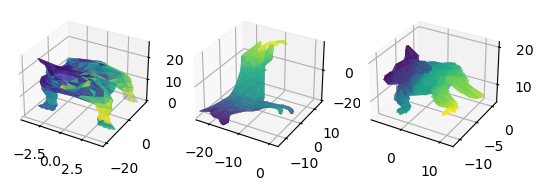

84.429184:  51%|██████████████████████████████████████████████████████████████████████████████                                                                           | 5100/10000 [2:47:59<2:02:04,  1.49s/it]

Epoch 5100: MSE loss = 72.90951538085938
Epoch 5100: Energy loss = 11.423993110656738
Epoch 5100: f1 loss = 0.005810747388750315
Epoch 5100: f2 loss = 0.08986225724220276


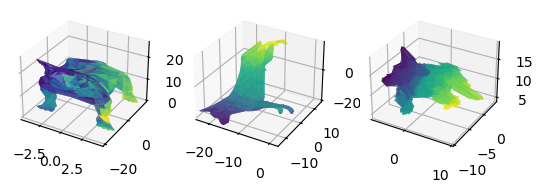

450.419678:  52%|███████████████████████████████████████████████████████████████████████████████                                                                         | 5200/10000 [2:51:21<2:03:37,  1.55s/it]

Epoch 5200: MSE loss = 83.13867950439453
Epoch 5200: Energy loss = 15.673971176147461
Epoch 5200: f1 loss = 346.8845520019531
Epoch 5200: f2 loss = 4.722484588623047


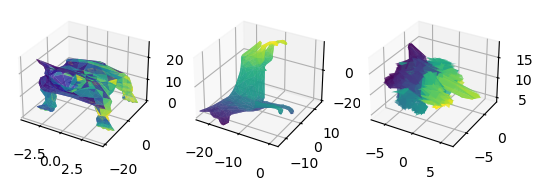

73.158928:  53%|█████████████████████████████████████████████████████████████████████████████████                                                                        | 5300/10000 [2:54:50<1:42:45,  1.31s/it]

Epoch 5300: MSE loss = 49.130828857421875
Epoch 5300: Energy loss = 12.511900901794434
Epoch 5300: f1 loss = 11.332438468933105
Epoch 5300: f2 loss = 0.18375878036022186


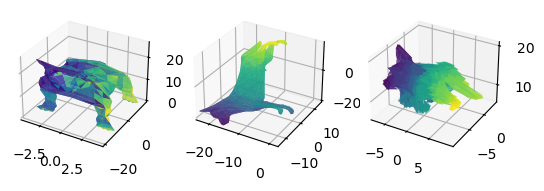

74.434235:  54%|██████████████████████████████████████████████████████████████████████████████████▌                                                                      | 5400/10000 [2:58:15<1:57:11,  1.53s/it]

Epoch 5400: MSE loss = 61.00910186767578
Epoch 5400: Energy loss = 13.421124458312988
Epoch 5400: f1 loss = 0.0034101279452443123
Epoch 5400: f2 loss = 0.0005997715052217245


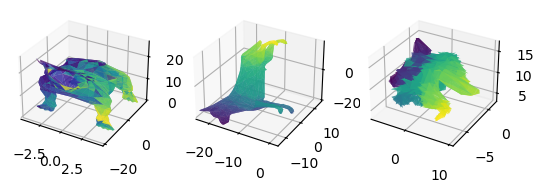

74.866058:  55%|████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 5500/10000 [3:01:44<1:42:53,  1.37s/it]

Epoch 5500: MSE loss = 59.64122009277344
Epoch 5500: Energy loss = 15.090228080749512
Epoch 5500: f1 loss = 0.018885118886828423
Epoch 5500: f2 loss = 0.11572907865047455


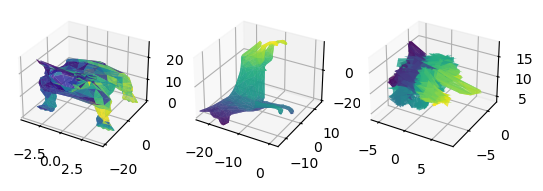

61.153816:  56%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 5600/10000 [3:05:14<1:53:24,  1.55s/it]

Epoch 5600: MSE loss = 46.63825988769531
Epoch 5600: Energy loss = 14.51231575012207
Epoch 5600: f1 loss = 0.0013059302000328898
Epoch 5600: f2 loss = 0.0019316618563607335


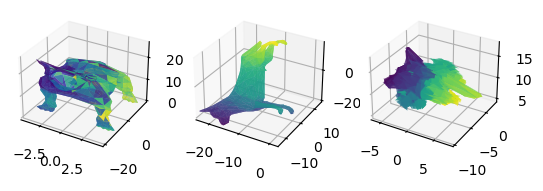

96.455498:  57%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 5700/10000 [3:09:03<2:02:19,  1.71s/it]

Epoch 5700: MSE loss = 80.50399017333984
Epoch 5700: Energy loss = 14.689935684204102
Epoch 5700: f1 loss = 1.241753339767456
Epoch 5700: f2 loss = 0.019820403307676315


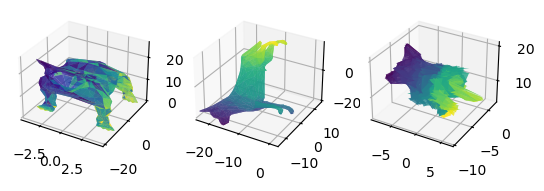

74.350777:  58%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 5800/10000 [3:12:52<1:49:28,  1.56s/it]

Epoch 5800: MSE loss = 62.22893142700195
Epoch 5800: Energy loss = 12.084227561950684
Epoch 5800: f1 loss = 0.002362170722335577
Epoch 5800: f2 loss = 0.0352545902132988


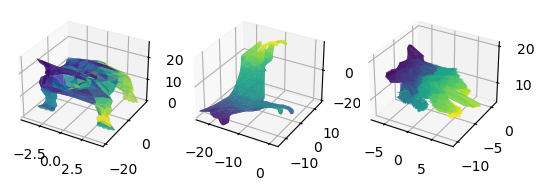

170.655182:  59%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 5900/10000 [3:16:28<1:51:50,  1.64s/it]

Epoch 5900: MSE loss = 158.05934143066406
Epoch 5900: Energy loss = 12.592269897460938
Epoch 5900: f1 loss = 0.00320369191467762
Epoch 5900: f2 loss = 0.00037174910539761186


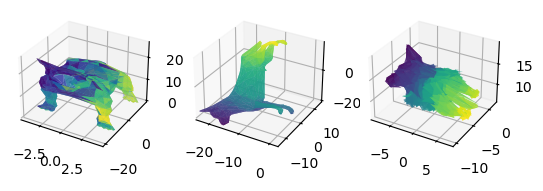

128.249451:  60%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 6000/10000 [3:20:04<1:39:52,  1.50s/it]

Epoch 6000: MSE loss = 90.55164337158203
Epoch 6000: Energy loss = 14.795979499816895
Epoch 6000: f1 loss = 0.005473766475915909
Epoch 6000: f2 loss = 22.8963623046875


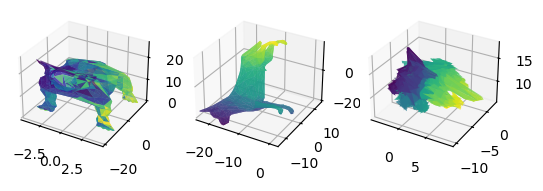

79.735710:  61%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 6100/10000 [3:24:19<1:37:32,  1.50s/it]

Epoch 6100: MSE loss = 69.58786010742188
Epoch 6100: Energy loss = 9.80348014831543
Epoch 6100: f1 loss = 0.26468169689178467
Epoch 6100: f2 loss = 0.07968537509441376


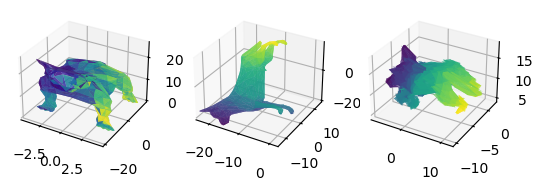

62.122410:  62%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 6200/10000 [3:27:48<1:23:25,  1.32s/it]

Epoch 6200: MSE loss = 46.6884880065918
Epoch 6200: Energy loss = 15.059398651123047
Epoch 6200: f1 loss = 0.00489977328106761
Epoch 6200: f2 loss = 0.3696241080760956


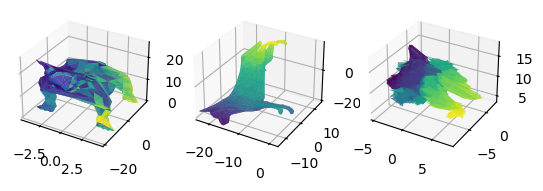

104.171524:  63%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 6300/10000 [3:31:22<1:37:51,  1.59s/it]

Epoch 6300: MSE loss = 91.8114013671875
Epoch 6300: Energy loss = 12.31852912902832
Epoch 6300: f1 loss = 0.014882151037454605
Epoch 6300: f2 loss = 0.02671211212873459


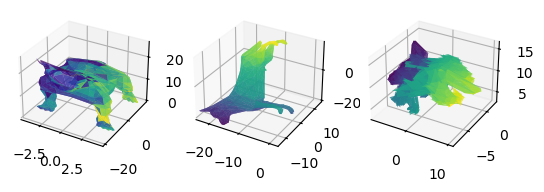

85.573715:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 6400/10000 [3:34:49<1:19:10,  1.32s/it]

Epoch 6400: MSE loss = 74.81857299804688
Epoch 6400: Energy loss = 10.572466850280762
Epoch 6400: f1 loss = 0.1481216847896576
Epoch 6400: f2 loss = 0.03455916419625282


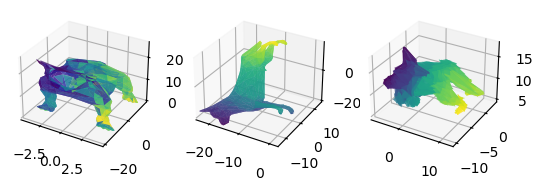

94.458603:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 6500/10000 [3:38:17<1:28:41,  1.52s/it]

Epoch 6500: MSE loss = 76.0320053100586
Epoch 6500: Energy loss = 18.423580169677734
Epoch 6500: f1 loss = 0.0023540270049124956
Epoch 6500: f2 loss = 0.0006665781838819385


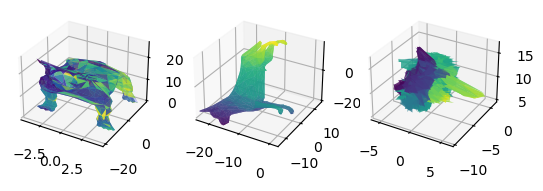

98.334946:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 6600/10000 [3:41:51<1:17:36,  1.37s/it]

Epoch 6600: MSE loss = 83.62423706054688
Epoch 6600: Energy loss = 14.708995819091797
Epoch 6600: f1 loss = 0.00014611922961194068
Epoch 6600: f2 loss = 0.0015667061088606715


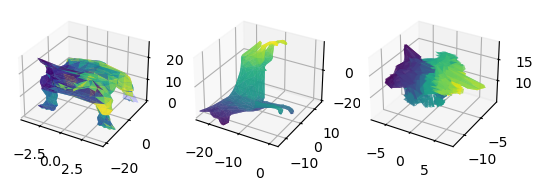

111.897476:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 6700/10000 [3:45:24<1:26:50,  1.58s/it]

Epoch 6700: MSE loss = 99.60868835449219
Epoch 6700: Energy loss = 12.274126052856445
Epoch 6700: f1 loss = 0.012867055833339691
Epoch 6700: f2 loss = 0.0017963218269869685


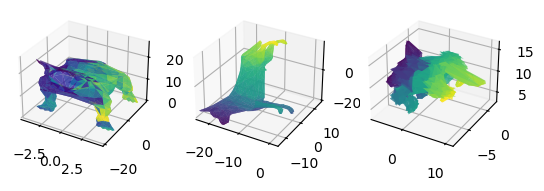

112.661697:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 6800/10000 [3:48:52<1:21:45,  1.53s/it]

Epoch 6800: MSE loss = 98.41017150878906
Epoch 6800: Energy loss = 14.093432426452637
Epoch 6800: f1 loss = 0.15528617799282074
Epoch 6800: f2 loss = 0.002811260288581252


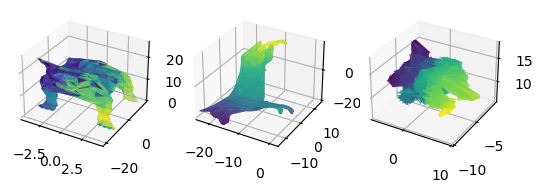

137.543533:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 6900/10000 [3:52:26<1:18:06,  1.51s/it]

Epoch 6900: MSE loss = 125.50194549560547
Epoch 6900: Energy loss = 12.027569770812988
Epoch 6900: f1 loss = 0.002276299288496375
Epoch 6900: f2 loss = 0.01174819003790617


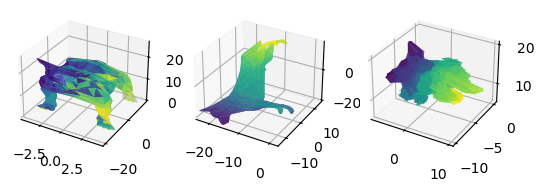

84.038971:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 7000/10000 [3:55:53<1:14:34,  1.49s/it]

Epoch 7000: MSE loss = 71.02739715576172
Epoch 7000: Energy loss = 13.001675605773926
Epoch 7000: f1 loss = 0.004543713293969631
Epoch 7000: f2 loss = 0.005355107132345438


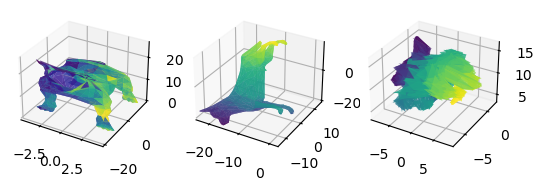

112.081505:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 7100/10000 [3:59:27<1:08:14,  1.41s/it]

Epoch 7100: MSE loss = 99.32754516601562
Epoch 7100: Energy loss = 12.460679054260254
Epoch 7100: f1 loss = 0.06804623454809189
Epoch 7100: f2 loss = 0.22523410618305206


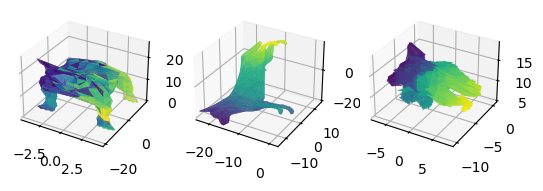

93.930611:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 7200/10000 [4:02:54<1:11:09,  1.52s/it]

Epoch 7200: MSE loss = 82.81610107421875
Epoch 7200: Energy loss = 11.084904670715332
Epoch 7200: f1 loss = 0.004419948905706406
Epoch 7200: f2 loss = 0.025184322148561478


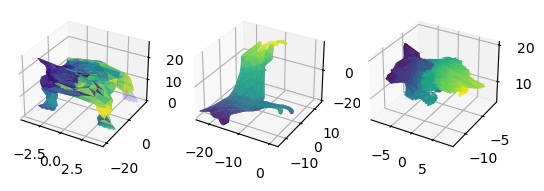

95.196014:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 7300/10000 [4:06:22<1:13:55,  1.64s/it]

Epoch 7300: MSE loss = 85.10733795166016
Epoch 7300: Energy loss = 10.070757865905762
Epoch 7300: f1 loss = 0.015638114884495735
Epoch 7300: f2 loss = 0.0022822923492640257


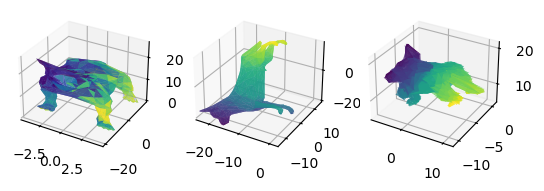

66.426727:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 7400/10000 [4:09:48<58:31,  1.35s/it]

Epoch 7400: MSE loss = 54.1306037902832
Epoch 7400: Energy loss = 12.259466171264648
Epoch 7400: f1 loss = 0.031549349427223206
Epoch 7400: f2 loss = 0.005110486410558224


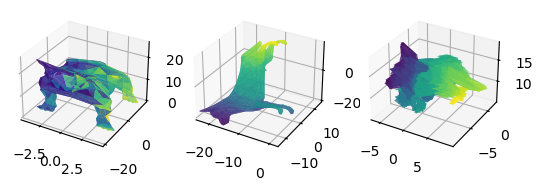

74.118683:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 7500/10000 [4:13:19<1:06:28,  1.60s/it]

Epoch 7500: MSE loss = 58.947784423828125
Epoch 7500: Energy loss = 15.165406227111816
Epoch 7500: f1 loss = 0.00507731270045042
Epoch 7500: f2 loss = 0.0004151529283262789


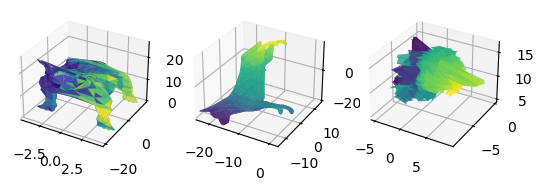

112.079765:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 7600/10000 [4:16:51<59:31,  1.49s/it]

Epoch 7600: MSE loss = 95.60213470458984
Epoch 7600: Energy loss = 14.913339614868164
Epoch 7600: f1 loss = 0.007361915893852711
Epoch 7600: f2 loss = 1.5569281578063965


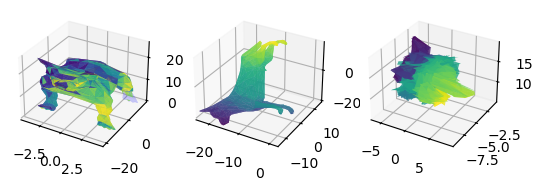

109.589630:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 7700/10000 [4:20:25<53:59,  1.41s/it]

Epoch 7700: MSE loss = 91.1583023071289
Epoch 7700: Energy loss = 17.238521575927734
Epoch 7700: f1 loss = 0.9923180937767029
Epoch 7700: f2 loss = 0.2004840224981308


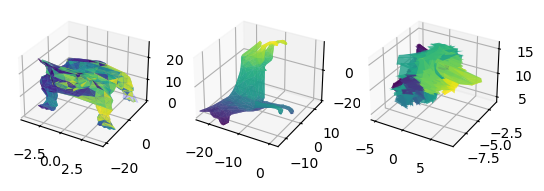

60.587887:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 7800/10000 [4:24:00<58:03,  1.58s/it]

Epoch 7800: MSE loss = 46.44302749633789
Epoch 7800: Energy loss = 14.135884284973145
Epoch 7800: f1 loss = 0.005710158962756395
Epoch 7800: f2 loss = 0.0032651035580784082


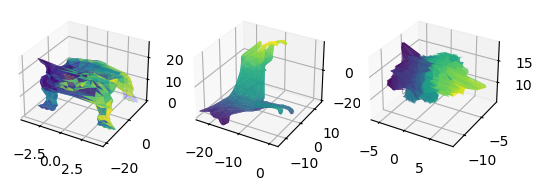

67.913170:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 7900/10000 [4:27:30<46:37,  1.33s/it]

Epoch 7900: MSE loss = 57.100833892822266
Epoch 7900: Energy loss = 10.788277626037598
Epoch 7900: f1 loss = 0.014254715293645859
Epoch 7900: f2 loss = 0.009805936366319656


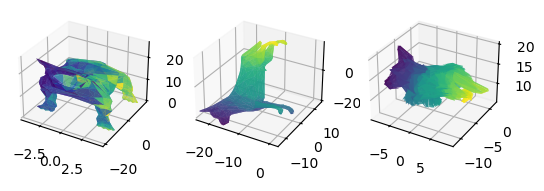

118.308685:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 8000/10000 [4:30:57<53:11,  1.60s/it]

Epoch 8000: MSE loss = 105.23762512207031
Epoch 8000: Energy loss = 10.98361587524414
Epoch 8000: f1 loss = 0.36695030331611633
Epoch 8000: f2 loss = 1.7204970121383667


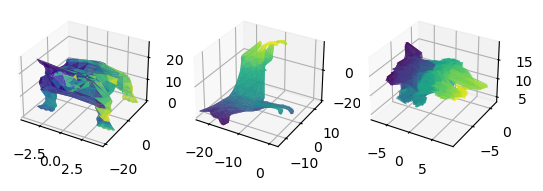

54.546375:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 8100/10000 [4:34:25<42:51,  1.35s/it]

Epoch 8100: MSE loss = 39.528953552246094
Epoch 8100: Energy loss = 13.3958101272583
Epoch 8100: f1 loss = 0.1911027580499649
Epoch 8100: f2 loss = 1.4305086135864258


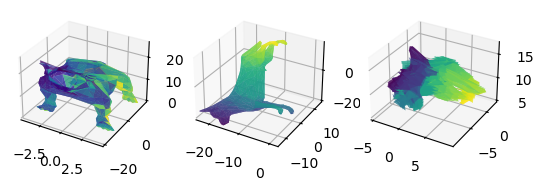

126.357414:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 8200/10000 [4:37:56<47:55,  1.60s/it]

Epoch 8200: MSE loss = 75.69306945800781
Epoch 8200: Energy loss = 12.745185852050781
Epoch 8200: f1 loss = 37.862144470214844
Epoch 8200: f2 loss = 0.0570170059800148


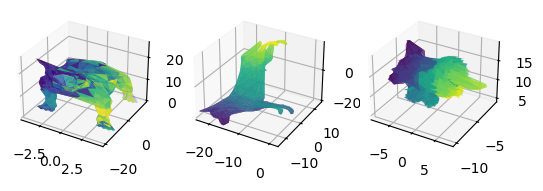

64.284576:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 8300/10000 [4:41:29<38:21,  1.35s/it]

Epoch 8300: MSE loss = 52.57515335083008
Epoch 8300: Energy loss = 11.286636352539062
Epoch 8300: f1 loss = 0.3183002471923828
Epoch 8300: f2 loss = 0.10448973625898361


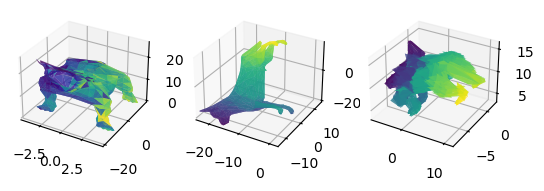

181.053802:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 8400/10000 [4:44:59<41:46,  1.57s/it]

Epoch 8400: MSE loss = 131.85736083984375
Epoch 8400: Energy loss = 12.667200088500977
Epoch 8400: f1 loss = 36.328189849853516
Epoch 8400: f2 loss = 0.20104777812957764


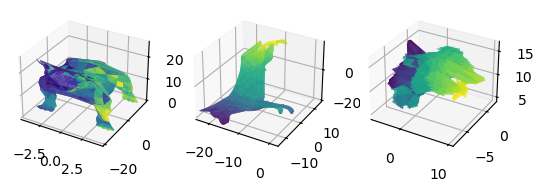

53.667122:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 8500/10000 [4:48:29<33:42,  1.35s/it]

Epoch 8500: MSE loss = 39.792659759521484
Epoch 8500: Energy loss = 13.852118492126465
Epoch 8500: f1 loss = 0.0017169727943837643
Epoch 8500: f2 loss = 0.020625099539756775


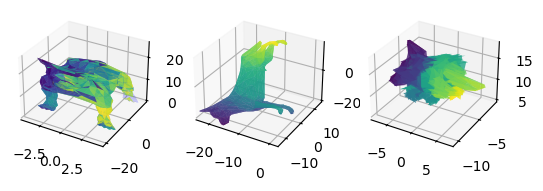

73.689117:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 8600/10000 [4:52:00<35:48,  1.53s/it]

Epoch 8600: MSE loss = 56.43167495727539
Epoch 8600: Energy loss = 17.253765106201172
Epoch 8600: f1 loss = 0.003165320260450244
Epoch 8600: f2 loss = 0.000515670282766223


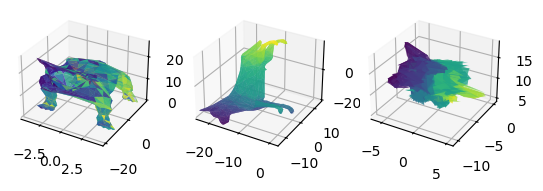

41.980648:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 8700/10000 [4:55:33<29:27,  1.36s/it]

Epoch 8700: MSE loss = 27.354936599731445
Epoch 8700: Energy loss = 14.616411209106445
Epoch 8700: f1 loss = 0.0050104218535125256
Epoch 8700: f2 loss = 0.004290134180337191


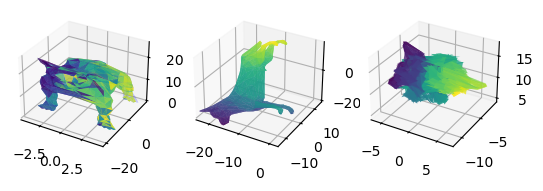

525402.000000:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 8800/10000 [4:59:08<30:24,  1.52s/it]

Epoch 8800: MSE loss = 71.76712799072266
Epoch 8800: Energy loss = 15.027170181274414
Epoch 8800: f1 loss = 525296.375
Epoch 8800: f2 loss = 18.85719108581543


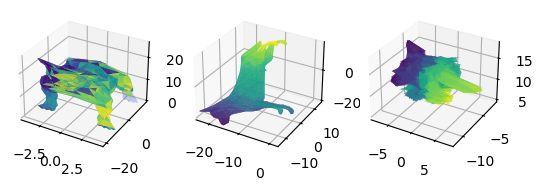

91.817207:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 8900/10000 [5:02:41<29:17,  1.60s/it]

Epoch 8900: MSE loss = 77.6731948852539
Epoch 8900: Energy loss = 13.827415466308594
Epoch 8900: f1 loss = 0.2539275586605072
Epoch 8900: f2 loss = 0.06266950815916061


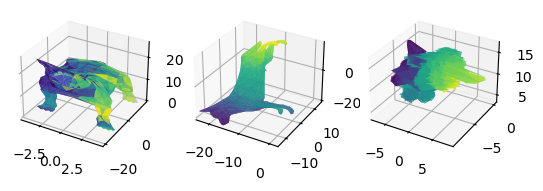

87.104935:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 9000/10000 [5:06:15<22:44,  1.36s/it]

Epoch 9000: MSE loss = 71.15874481201172
Epoch 9000: Energy loss = 15.872835159301758
Epoch 9000: f1 loss = 0.05758344382047653
Epoch 9000: f2 loss = 0.01577364094555378


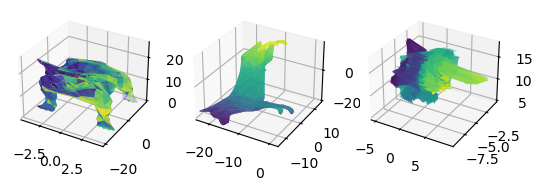

62.515560:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 9100/10000 [5:09:52<23:21,  1.56s/it]

Epoch 9100: MSE loss = 47.712852478027344
Epoch 9100: Energy loss = 13.635639190673828
Epoch 9100: f1 loss = 0.0022993297316133976
Epoch 9100: f2 loss = 1.164768099784851


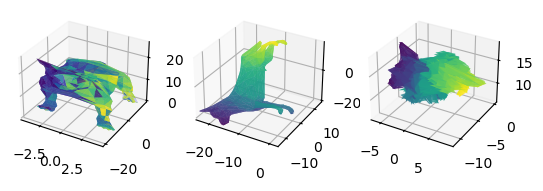

100.165710:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 9200/10000 [5:13:20<19:44,  1.48s/it]

Epoch 9200: MSE loss = 88.60223388671875
Epoch 9200: Energy loss = 11.088390350341797
Epoch 9200: f1 loss = 0.46549370884895325
Epoch 9200: f2 loss = 0.009596948511898518


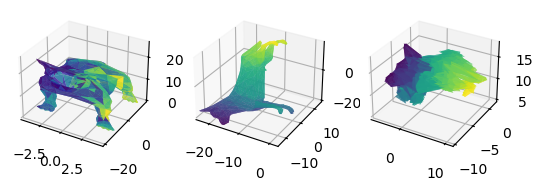

137.139374:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 9300/10000 [5:16:49<18:14,  1.56s/it]

Epoch 9300: MSE loss = 118.29869079589844
Epoch 9300: Energy loss = 18.438114166259766
Epoch 9300: f1 loss = 0.05490834638476372
Epoch 9300: f2 loss = 0.34766116738319397


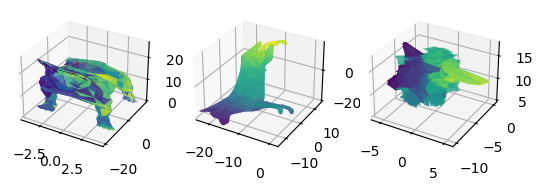

65.959839:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 9400/10000 [5:20:20<15:20,  1.53s/it]

Epoch 9400: MSE loss = 50.20254898071289
Epoch 9400: Energy loss = 14.71146011352539
Epoch 9400: f1 loss = 0.510416567325592
Epoch 9400: f2 loss = 0.5354181528091431


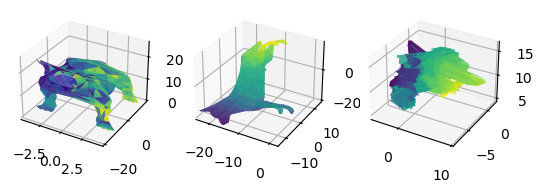

58.800320:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 9500/10000 [5:23:56<11:16,  1.35s/it]

Epoch 9500: MSE loss = 41.593177795410156
Epoch 9500: Energy loss = 16.789154052734375
Epoch 9500: f1 loss = 0.4135289788246155
Epoch 9500: f2 loss = 0.004458288662135601


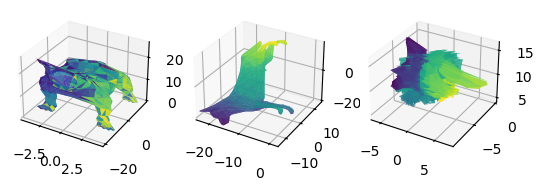

97.049278:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 9600/10000 [5:27:37<09:41,  1.45s/it]

Epoch 9600: MSE loss = 84.96973419189453
Epoch 9600: Energy loss = 12.059536933898926
Epoch 9600: f1 loss = 0.006253623869270086
Epoch 9600: f2 loss = 0.013752649538218975


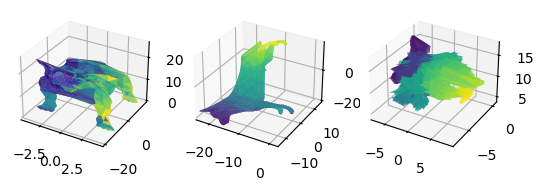

45.455379:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 9700/10000 [5:31:05<07:40,  1.54s/it]

Epoch 9700: MSE loss = 29.070720672607422
Epoch 9700: Energy loss = 13.887406349182129
Epoch 9700: f1 loss = 2.4899983406066895
Epoch 9700: f2 loss = 0.007254406344145536


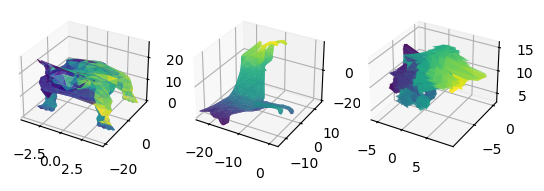

709.324646:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 9800/10000 [5:34:41<04:29,  1.35s/it]

Epoch 9800: MSE loss = 123.96302032470703
Epoch 9800: Energy loss = 12.735799789428711
Epoch 9800: f1 loss = 534.519775390625
Epoch 9800: f2 loss = 38.10610580444336


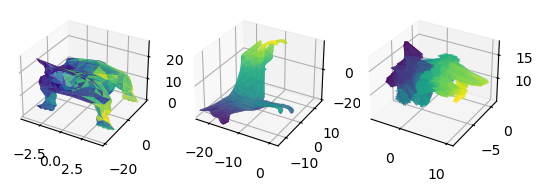

113.975517:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 9900/10000 [5:38:15<02:38,  1.59s/it]

Epoch 9900: MSE loss = 72.50479125976562
Epoch 9900: Energy loss = 13.458986282348633
Epoch 9900: f1 loss = 27.332685470581055
Epoch 9900: f2 loss = 0.6790546774864197


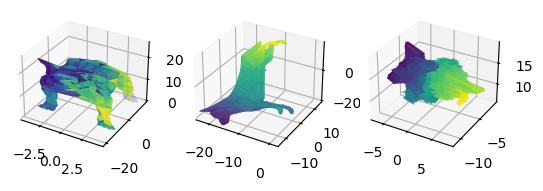

91.352242: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [5:41:46<00:00,  2.05s/it]


In [18]:
# %debug
# l = compute_l(my_batch)
# s3 = reconstruct_s2(my_batch2, v2_t, l)
optimizer_diffnet = optim.AdamW(diffusion_net.parameters() ,lr=0.001, weight_decay=0.001)
optimizer_diffnet_fts = optim.AdamW(diff_net_fts.parameters() ,lr=0.001, weight_decay=0.001)
optimizer_decoder = optim.AdamW(decoder.parameters() ,lr=0.001, weight_decay=0.001)
for epoch in (pbar:=tqdm(range(10000))):
    l = compute_l(my_batch, diffusion_net)
    l.retain_grad()
    s3 = reconstruct_s2(my_batch2, v2_t, l, decoder)
    s3.features.retain_grad()
    ###################################
    C1, C2, p2p_21 = compute_fmaps(my_batch, my_batch2, diff_net_fts)
    C1.retain_grad()
    C2.retain_grad()
    # p2p_21.retain_grad()
    ###################################
    v1_remapped = v1[p2p_21]
    loss_MSE = torch.nn.functional.mse_loss(torch.Tensor(v1_remapped),s3.features)
    loss_FMAPS_1 = torch.nn.functional.mse_loss(C1@C2, torch.eye(50)) + torch.nn.functional.mse_loss(C1.transpose(1,2)@C1, torch.eye(50)) 
    loss_FMAPS_2 = torch.nn.functional.mse_loss(C2@C1, torch.eye(50)) + torch.nn.functional.mse_loss(C2.transpose(1,2)@C1, torch.eye(50)) 
    loss_E = get_energy_loss(s3.transformed_prism, s3.rotations, s3.pos.reshape(-1, 3), s3.face) 
    total_loss = 1e-10*loss_FMAPS_1 + 1e-10*loss_FMAPS_2 + loss_MSE + loss_E*10
    pbar.set_description(f"{total_loss.detach():3f}")
    loss_MSE.retain_grad()
    loss_FMAPS_1.retain_grad()
    loss_FMAPS_2.retain_grad()
    loss_E.retain_grad()
    total_loss.backward()
    # import ipdb; ipdb.set_trace()
    # my_batch2.pos = my_batch2.pos.squeeze(0)
    optimizer_diffnet.step()
    optimizer_diffnet.zero_grad()
    optimizer_decoder.step()
    optimizer_decoder.zero_grad()
    optimizer_diffnet_fts.step()
    optimizer_diffnet_fts.zero_grad()
    if epoch%100 == 0:
        print(f'Epoch {epoch}: MSE loss = {loss_MSE}')
        print(f'Epoch {epoch}: Energy loss = {10*loss_E}')
        print(f'Epoch {epoch}: f1 loss = {1e-10*loss_FMAPS_1}')
        print(f'Epoch {epoch}: f2 loss = {1e-10*loss_FMAPS_2}')
        verts = my_batch2.pos.reshape(-1, 3)
        faces = my_batch2.face.t()
        s2_faces = verts[faces].detach().numpy()
        s3_faces = s3.transformed_prism.detach().squeeze(0).numpy()
        # closest_faces_idx = find_closest_faces(s3_faces, s1_faces_tmp)
        closest_faces_idx = find_closest_faces(s1_faces_tmp,s3_faces)#, s1_faces_tmp)
        s1_faces = s1_faces_tmp[closest_faces_idx]
        visu_face_colors(s1_faces_tmp, s1_faces, s2_faces, s3_faces)
        plt.show()

In [19]:
print(s3_faces.shape)
print(s1_faces_tmp.shape)
print(s1_faces.shape)

(970, 3, 3)
(1078, 3, 3)
(970, 3, 3)


In [20]:
lf1, lf2 = s1_faces_tmp, s3_faces

centroids_lf1 = np.array([compute_centroid(face) for face in lf1])
centroids_lf2 = np.array([compute_centroid(face) for face in lf2])

closest_faces = []
closest_faces_idx = []

for centroid in centroids_lf2:
    distances = np.linalg.norm(centroids_lf1 - centroid, axis=1)
    closest_face_idx = np.argmin(distances)
    while closest_face_idx in closest_faces_idx:
        distances[closest_face_idx] = max(distances) + 1
        # print(closest_face_idx, np.argmin(distances))
        closest_face_idx = np.argmin(distances)
    closest_faces.append(lf1[closest_face_idx])
    closest_faces_idx.append(closest_face_idx)
print(len(closest_faces_idx))
print(max(closest_faces_idx))

# for centroid in centroids_lf2:
#     distances = np.linalg.norm(centroids_lf1 - centroid, axis=1)
#     closest_face_idx = np.argmin(distances)
#     while closest_face_idx in closest_faces_idx:
#         distances[closest_face_idx] = max(distances) + 1
#         # print(closest_face_idx, np.argmin(distances))
#         closest_face_idx = np.argmin(distances)
#     closest_faces.append(lf1[closest_face_idx])
#     closest_faces_idx.append(closest_face_idx)
# print(len(closest_faces_idx))
# print(max(closest_faces_idx))

970
1077


In [21]:
v1s = my_batch.pos.detach().numpy()[0]
v3s = s3.features.detach().squeeze(0).numpy()[0]
print(v1s, v3s)

[[ 3.1602659e+00 -1.0895985e+01  1.0343000e-02]
 [ 3.7360101e+00 -1.1155475e+01  4.6799000e-02]
 [ 5.8451301e-01 -1.9746441e+01  2.1269619e+01]
 ...
 [-1.0321780e+00  1.3775474e+01  8.3145781e+00]
 [-7.1533501e-01  1.1227485e+01  1.3906136e+01]
 [-3.3355400e-01  1.4022309e+01  7.2379370e+00]] [-1.09389   -3.4720056  7.0445876]


In [22]:
np.save('shape1_baseline.npy', v1_remapped)
np.save('shape2_reconstruction.npy', s3.features.detach().squeeze(0).numpy())
